***



<div class="alert alert-info" id="top"><center>

### ###    
    
# UNSIGNED PLAY BY MILAN KUNDERA?

### ###    
    
### Petr Plecháč<sup>1</sup> & Lenka Jungmannová<sup>2</sup>
    
---
    
> <sup>1</sup> Institute of Czech Literature CAS, plechac@ucl.cas.cz, ORCID: [0000-0002-1003-4541](https://orcid.org/0000-0002-1003-4541)
    
> <sup>2</sup> Institute of Czech Literature CAS, jungmannova@ucl.cas.cz, ORCID: [0000-0003-1704-2023](https://orcid.org/0000-0003-1704-2023)

</center></div>
    
***

* [Functions](#functions)
* [Load datasets](#load)
* [Support Vector Machine](#svm1)
* [Support Vector Machine (without *Sun*)](#svm2)
* [Dendrograms](#dendro)

In [1]:
import re
import os
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from collections import defaultdict
import random
import math
from scipy.spatial.distance import pdist, squareform

<div id="functions" ></div>
&nbsp;
&nbsp;

<font size="1"> Functions » [Load datasets](#load) » [Support Vector Machine](#svm1) » [Support Vector Machine (without *Sun*)](#svm2) » [Dendrograms](#dendro)</font>

<div class="alert alert-warning"><center>

### Functions
    
</center></div>

In [17]:
def _prepare_df(datasets, feature, mft, zscore=True):
    '''
    Prepare dataframe for classification. This involves merging multiple dataframes (if -feature- is list-like)
    and transforming the data (MFT, relative frequencies, z-score transformation)
    ---
    datasets  {dict}      : dict holding dataframes for particular features
    feature   {str|list}  : name(s) of feature sets to be used
    mft_list  {list|set}  : list of different levels of MFT that should be used
    zscore    {bool}      : whether to perform z-score transformation
    '''

    # If feature is a single string, only transform the dataframe
    if isinstance(feature, str):
        df = _transform_df(datasets[feature], mft=mft, zscore=True)

    # Otherwise merge multiple dataframes into one and transform it
    else:
        dfs = list()
        for f in feature:
            df_ = _transform_df(datasets[f], mft=mft, zscore=True)
            dfs.append(df_)
        df = pd.concat(dfs, axis=1)
        
    return df
        
        
def _transform_df(df, mft=None, zscore=False):
    '''
    (1) Slice dataframe to [M]ost [F]requent [T]ypes, 
    (2) absolute to relative frequencies, 
    (3) z-score transformation
    ---
    df:       {df}        : dataframe holding abslute frequencies
    mft_list  {list|set}  : list of different levels of MFT that should be used
    zscore    {bool}      : whether to perform z-score transformation
    '''
    
    # If number of [m]ost [f]requent [t]ypes specified: 
    # slice the dataframe
    if mft:
        df = df.iloc[: , :mft] 
        
    # Transform absolute frequencies to relative frequencies   
    df = df.div(df.sum(axis=1), axis=0)   
        
    # Z-score transformation
    if zscore:
        df = (df - df.mean())/df.std(ddof=0)
      
    return df


def _random_slice(train_data):
    '''
    Level the number of Steigerwald's samples to the number of Kundera's samples by random
    ---
    train_data  {dict}  : dict holding all training data
    '''
    
    random.shuffle(train_data['STEIGERWALD'])
    train_data['STEIGERWALD'] = train_data['STEIGERWALD'][:len(train_data['KUNDERA'])]
    X_train = train_data['KUNDERA'] + train_data['STEIGERWALD']
    y_train = ['KUNDERA'] * len(train_data['KUNDERA']) + ['STEIGERWALD'] * len(train_data['STEIGERWALD'])
    
    return X_train, y_train


def svm(datasets, train_set, test_set, feature_list, mft_list, n_iter=1000, zscore=True, kernel='linear', C=1):
    '''
    Perform both SVM cross-validation of training data and classification of disputed text
    ---
    datasets     {dict}        : dict holding dataframes for particular features
    train_set     {list}       : play titles to be included into train set
    test_set    {list}         : play titles to be included into test set
    feture_list  {list|set}    : list of features to be used (list items are either strings or lists/sets in
                                 case when concatenated feature space should be used; e.g. [trigrams, lemmata])
    mft_list     {list|set}    : list of different levels of MFT that should be used
    n_iter       {int}         : number of classifications with random sampling
    zscore       {bool}        : whether to perform z-score transformation
    kernel       {str}         : SVM kernel ("linear", "poly", "rbf", "sigmoid", "precomputed"), see link below
    C            {float}       : SVM penalty, see link below
    ---
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    '''
    
    # Bins for cross-validation and classification results
    cv_results = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    cl_results = defaultdict(lambda: defaultdict(int))

    # Iterate over different levels of MFT
    for mft in mft_list:

        # Iterate over different feature spaces
        for feature in feature_list:
            print(mft, feature)
            
            # Prepare dataframe
            df = _prepare_df(datasets, feature, mft=mft, zscore=True)

            # Perform requested number of iterations
            for rand_iter in range(n_iter):

                #
                # Cross validation
                #

                # Iterate over plays with known authorship
                for test_doc in train_set:
                    X_train, y_train, X_test, y_test = ([] for _ in range(4))
                    train_data = defaultdict(list) 
                    n_samples = 0

                    # Split to test and train set
                    for index, row in df.iterrows():
                        author, title = index.split(' - ')
                        title_clean = re.sub('\([^\)]+\)', '', title).strip() 
                        if title_clean not in train_set:
                            continue
                        if title_clean == test_doc:
                            X_test.append(row)
                            y_test.append(author)
                        else:
                            train_data[author].append(row)

                    # Level train set (so that both authors have equal number of training samples)
                    X_train, y_train = _random_slice(train_data)

                    # Train model and classify test set
                    clf = SVC(kernel=kernel, C=C)
                    clf.fit(X_train, y_train)
                    predicted = clf.predict(X_test)

                    # Store accuracy and misclassification type
                    for p,y in zip(predicted, y_test):
                        if p == y:
                            cv_results['T'][test_doc][str(mft)+'_'+str(feature)] += 1
                        else:
                            cv_results['F'][test_doc][str(mft)+'_'+str(feature)] += 1

                #
                # Classification of TARGET
                #

                X_train, y_train, X_test, y_test = ([] for _ in range(4))
                train_data = defaultdict(list) 

                # Split to train and classification set
                for index, row in df.iterrows():
                    author, title = index.split(' - ')
                    title_clean = re.sub('\([^\)]+\)', '', title).strip() 
                    
                    if title_clean in test_set:
                        X_test.append(row)
                        y_test.append(author)
                    elif title_clean in train_set:
                        train_data[author].append(row)

                # Level train set (so that both authors have equal number of training samples)
                X_train, y_train = _random_slice(train_data)

                # Train model and perform classification
                clf = SVC(kernel=kernel, C=C)
                clf.fit(X_train, y_train)
                predicted = clf.predict(X_test)

                # Store results
                for p in predicted:
                    cl_results[str(mft)+'_'+str(feature)][p] += 1

    return cv_results, cl_results                


def print_cv_results(cv_results):
    '''
    Print cross-validation results in a table (plays X features => accuracy) 
    both as a heatmap and in LaTeX format
    '''
    
    # Transform results into dataframe
    dft = pd.DataFrame(cv_results['T']).fillna(0)
    dff = pd.DataFrame(cv_results['F']).fillna(0)

    acc_docs_feats = (dft/(dft+dff)).fillna(1)
    acc_docs       = (dft.sum(axis=0) / (dft.sum(axis=0) + dff.sum(axis=0))).fillna(1)
    acc_feats      = (dft.sum(axis=1) / (dft.sum(axis=1) + dff.sum(axis=1))).fillna(1)
    acc_tot        = dft.to_numpy().sum() / (dft.to_numpy().sum() + dff.to_numpy().sum())

    acc = acc_docs_feats.append(acc_docs.rename('all'))
    acc['all'] = acc_feats
    acc.loc['all','all'] = acc_tot 
    
    # Plot heatmap
    print('-'*40, 'HEATMAP')
    fig = plt.figure(figsize=(12,8))
    sns.heatmap(acc.round(2).T, annot=True, cbar=False, cmap='Purples')
    plt.show()
    
    # Print LaTeX table
    print('-'*40, 'LATEX')
    acc_dict = acc.to_dict()

    for play in ('Owners', 'Blunder', 'Jacques', 'Sun', 'Fair', 'Dances', 'Foxtrot', 'Prince', 'all'):
        if play not in acc_dict:
            continue
        if play == 'all':
            print('\\multicolumn{2}{c}{\\textit{all}}', end = ' ')
        else:
            if play == 'Owners':
                print('Kundera', end=' ')
            elif play == 'Sun':
                print('Steigerwald', end=' ')
            print('& {} '.format(play), end =' ')
        for f in (
            '500_words', '750_words', '1000_words', '1500_words',
            '500_lemmata', '750_lemmata', '1000_lemmata', '1500_lemmata',
            '500_trigrams', '750_trigrams', '1000_trigrams', '1500_trigrams',
            '500_(\'lemmata\', \'trigrams\')', '750_(\'lemmata\', \'trigrams\')', 
            '1000_(\'lemmata\', \'trigrams\')', '1500_(\'lemmata\', \'trigrams\')',
            'all'
        ):
            if play == 'all' or f == 'all':
                print('&\\textit{' +  str(round(acc_dict[play][f], 2)) +'} ', end='')
            else:
                print('&'+str(round(acc_dict[play][f], 2)), end='')
        print(' \\\\')


def _plot_dendrogram_subplot(df, metric='cosine', method='complete'):
    '''
    Plot single dendrogram
    ---
    df:      {df}        dataframe holding abslute frequencies
    metric:  {string}    metric by which distance will be calculated, for list of options see link below
    method:  {string}    linkage criterion, for list of options see link below
    ---
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    '''
        
    # Create linkage matrix
    linkage_matrix = linkage(df, method=method, metric=metric)
            
    # Assign color to authors
    (leaves, colors) = (list(), dict())
    for sample in list(df.index):    
        leaves.append(sample)
        text_name = re.sub(' \(.*$', '', sample)
        if 'KUNDERA' in sample:
            colors[sample] = 'r'
        elif 'STEIGERWALD' in sample:
            colors[sample] = 'g'
        else:
            colors[sample] = 'b'
        
    # Plot dendrogram
    ddata = dendrogram(linkage_matrix, color_threshold=0.00001, labels=leaves, orientation='right', leaf_font_size=14)
    ax = plt.gca()
    ax.set_xlim(0.6,1.3)
    xlbls = ax.get_ymajorticklabels()
    for lbl in xlbls:
        lbl.set_color(colors[lbl.get_text()])    
        
    
def plot_dendrograms(datasets, feature_list, mft_list, metric='cosine', 
                     method='complete', zscore=True, file=None, figsize=(20,20)):
    '''
    Plot multiple dendrograms for different feature spaces and different levels of MFT
    ---
    datasets     {dict}        : dict holding dataframes for particular features
    feture_list  {list|set}    : list of features to be used (list items are either strings or lists/sets in
                                 case when concatenated feature space should be used; e.g. [trigrams, lemmata])
    mft_list     {list|set}    : list of different levels of MFT that should be used
    metric       {string}      : metric by which distance will be calculated, for list of options see link below
    method       {string}      : linkage criterion, for list of options see link below
    zscore       {bool}        : whether to perform z-score transformation
    file         {string|None} : path to file where figure will be stored or None for not saving figure to file
    figsize      {list|set}    : size of the figure (width, heighth)
    ---
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    '''
    
    # Initialize figure
    fig   = plt.figure(figsize=figsize)
    # Initialize subplot counter
    n_subplot = 1

    # Iterate over different levels of MFT
    for mft in mft_list:

        # Iterate over features
        for feature in feature_list:

            # Start new subplot
            plt.subplot(len(mft_list), len(feature_list), n_subplot)

            # Plot dendrogram
            df = _prepare_df(datasets, feature, mft=mft, zscore=True)
            _plot_dendrogram_subplot(df, metric=metric, method=method)

            # Feature labels for bottom subplots
            if n_subplot > (len(mft_list) - 1) * len(feature_list):
                plt.xlabel('{}'.format(feature), fontsize=18)
    
            # MFT labels for rightmost subplots
            if (n_subplot - 1) % len(feature_list) == 0:
                plt.ylabel('MFT = {}'.format(mft), fontsize=18)
            plt.title('( {} )'.format(chr(ord('`') + n_subplot)))

            n_subplot += 1

    # Plot and save figure
    plt.tight_layout() 
    if file:
        plt.savefig(file)
    plt.show()
    plt.close()

<div id="load" ></div>
&nbsp;
&nbsp;

<font size="1"> [Functions](#functions) » Load datasets » [Support Vector Machine](#svm1) » [Support Vector Machine (without *Sun*)](#svm2) » [Dendrograms](#dendro)</font>

<div class="alert alert-success"><center>

### Load datasets
    
</center></div>

In [2]:
# Build DataFrames from JSON files
datasets = dict()
for f in ('lemmata', 'words', 'trigrams'):
    print('loading:', f)
    datasets[f] = pd.read_json(os.path.join('json', f + '.json'))
    

loading: lemmata
loading: words
loading: trigrams


<div id="svm1" ></div>
&nbsp;
&nbsp;

<font size="1"> [Functions](#functions) » [Load datasets](#load) » Support Vector Machine » [Support Vector Machine (without *Sun*)](#svm2) » [Dendrograms](#dendro)</font>

<div class="alert alert-success"><center>

### Support Vector Machine

</center></div>

In [4]:
# Cross-validation and classification of disputed text
cv_results, cl_results = svm(
    datasets     = datasets, 
    train_set    = ('Blunder', 'Jacques', 'Owners', 'Sun', 'Dances', 'Fair', 'Foxtrot', 'Prince'),
    test_set     = ('Jánošík',),
    feature_list = ('lemmata', 'words', 'trigrams', ('lemmata', 'trigrams')), 
    mft_list     = (500, 750, 1000, 1500), 
    n_iter       = 1000, 
    zscore       = True, 
    kernel       = cosine_similarity, 
    C            = 1
)

500 lemmata
500 words
500 trigrams
500 ('lemmata', 'trigrams')
750 lemmata
750 words
750 trigrams
750 ('lemmata', 'trigrams')
1000 lemmata
1000 words
1000 trigrams
1000 ('lemmata', 'trigrams')
1500 lemmata
1500 words
1500 trigrams
1500 ('lemmata', 'trigrams')


---------------------------------------- HEATMAP


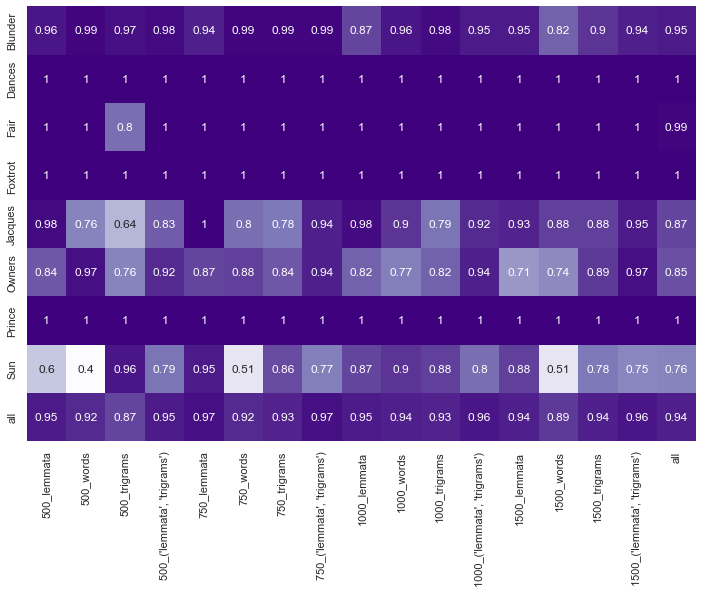

---------------------------------------- LATEX
Kundera & Owners  &0.97&0.88&0.77&0.74&0.84&0.87&0.82&0.71&0.76&0.84&0.82&0.89&0.92&0.94&0.94&0.97&\textit{0.85}  \\
& Blunder  &0.99&0.99&0.96&0.82&0.96&0.94&0.87&0.95&0.97&0.99&0.97&0.9&0.98&0.99&0.95&0.94&\textit{0.95}  \\
& Jacques  &0.76&0.81&0.9&0.88&0.98&1.0&0.98&0.93&0.64&0.78&0.79&0.88&0.83&0.94&0.92&0.95&\textit{0.87}  \\
Steigerwald & Sun  &0.4&0.51&0.9&0.51&0.6&0.95&0.87&0.88&0.96&0.86&0.88&0.78&0.79&0.77&0.8&0.75&\textit{0.76}  \\
& Fair  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&0.8&1.0&1.0&1.0&1.0&1.0&1.0&1.0&\textit{0.99}  \\
& Dances  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&\textit{1.0}  \\
& Foxtrot  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&\textit{1.0}  \\
& Prince  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&\textit{1.0}  \\
\multicolumn{2}{c}{\textit{all}} &\textit{0.92} &\textit{0.92} &\textit{0.94} &\textit{0.89} &\textit{0.95} &\textit{0.97} &\textit{0.95}

In [7]:
# Cross-validation results (heatmap & LaTeX table)
print_cv_results(cv_results)

In [8]:
# Disputed text results
print(' '*55, 'KUNDERA'.ljust(15), 'STEIGERWALD')

for f in cl_results:
    for a in ('KUNDERA', 'STEIGERWALD'):
        if a not in cl_results[f]:
            cl_results[f][a] = 0
    print(f.rjust(50), ' '*4,  str(cl_results[f]['KUNDERA']).ljust(15), cl_results[f]['STEIGERWALD'])

                                                        KUNDERA         STEIGERWALD
                                       500_lemmata      3000            0
                                         500_words      3000            0
                                      500_trigrams      3000            0
                       500_('lemmata', 'trigrams')      3000            0
                                       750_lemmata      3000            0
                                         750_words      3000            0
                                      750_trigrams      3000            0
                       750_('lemmata', 'trigrams')      3000            0
                                      1000_lemmata      3000            0
                                        1000_words      3000            0
                                     1000_trigrams      3000            0
                      1000_('lemmata', 'trigrams')      3000            0
                            

<div id="svm2" ></div>
&nbsp;
&nbsp;

<font size="1"> [Functions](#functions) » [Load datasets](#load) » [Support Vector Machine](#svm1) » Support Vector Machine (without *Sun*) » [Dendrograms](#dendro)</font>

<div class="alert alert-success"><center>

### Support Vector Machine (without *Sun*)
    
</center></div>

In [9]:
# Cross-validation and classification of disputed text
cv_results, cl_results = svm(
    datasets     = datasets, 
    train_set    = ('Blunder', 'Jacques', 'Owners', 'Dances', 'Fair', 'Foxtrot', 'Prince'),
    test_set     = ('Jánošík',),
    feature_list = ('lemmata', 'words', 'trigrams', ('lemmata', 'trigrams')), 
    mft_list     = (500, 750, 1000, 1500), 
    n_iter       = 1000, 
    zscore       = True, 
    kernel       = 'linear', 
    C            = 1
)

500 lemmata
500 words
500 trigrams
500 ('lemmata', 'trigrams')
750 lemmata
750 words
750 trigrams
750 ('lemmata', 'trigrams')
1000 lemmata
1000 words
1000 trigrams
1000 ('lemmata', 'trigrams')
1500 lemmata
1500 words
1500 trigrams
1500 ('lemmata', 'trigrams')


---------------------------------------- HEATMAP


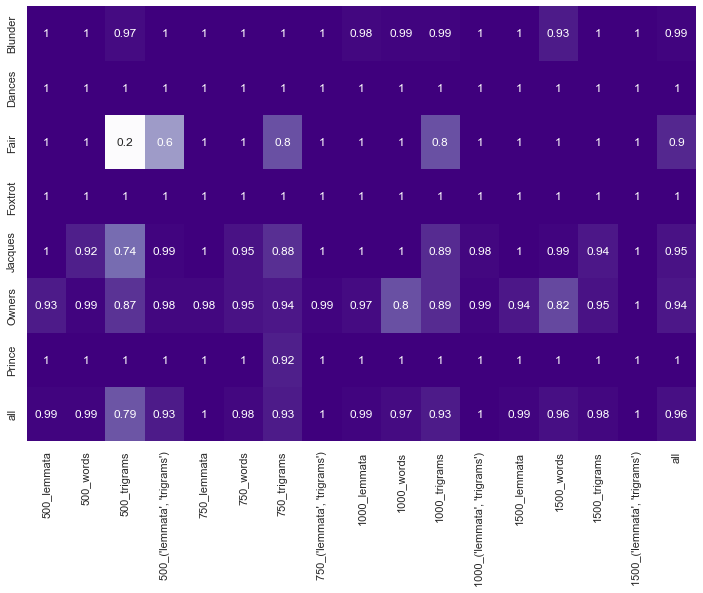

---------------------------------------- LATEX
Kundera & Owners  &0.99&0.95&0.81&0.82&0.93&0.98&0.97&0.94&0.87&0.94&0.89&0.95&0.98&0.99&0.99&1.0&\textit{0.94}  \\
& Blunder  &1.0&1.0&0.99&0.93&1.0&1.0&0.98&1.0&0.97&1.0&0.99&1.0&1.0&1.0&1.0&1.0&\textit{0.99}  \\
& Jacques  &0.92&0.95&1.0&0.99&1.0&1.0&1.0&1.0&0.74&0.89&0.89&0.94&0.99&1.0&0.98&1.0&\textit{0.95}  \\
& Fair  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&0.2&0.8&0.8&1.0&0.6&1.0&1.0&1.0&\textit{0.9}  \\
& Dances  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&\textit{1.0}  \\
& Foxtrot  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&\textit{1.0}  \\
& Prince  &1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&1.0&0.92&1.0&1.0&1.0&1.0&1.0&1.0&\textit{1.0}  \\
\multicolumn{2}{c}{\textit{all}} &\textit{0.99} &\textit{0.98} &\textit{0.97} &\textit{0.96} &\textit{0.99} &\textit{1.0} &\textit{0.99} &\textit{0.99} &\textit{0.79} &\textit{0.93} &\textit{0.93} &\textit{0.98} &\textit{0.93} &\textit{1.0} &\textit{1.0} &\textit{1.0

In [10]:
# Cross-validation results (heatmap & LaTeX table)
print_cv_results(cv_results)

In [11]:
# Disputed text results
print(' '*55, 'KUNDERA'.ljust(15), 'STEIGERWALD')

for f in cl_results:
    for a in ('KUNDERA', 'STEIGERWALD'):
        if a not in cl_results[f]:
            cl_results[f][a] = 0
    print(f.rjust(50), ' '*4,  str(cl_results[f]['KUNDERA']).ljust(15), cl_results[f]['STEIGERWALD'])

                                                        KUNDERA         STEIGERWALD
                                       500_lemmata      3000            0
                                         500_words      3000            0
                                      500_trigrams      3000            0
                       500_('lemmata', 'trigrams')      3000            0
                                       750_lemmata      3000            0
                                         750_words      3000            0
                                      750_trigrams      3000            0
                       750_('lemmata', 'trigrams')      3000            0
                                      1000_lemmata      3000            0
                                        1000_words      3000            0
                                     1000_trigrams      3000            0
                      1000_('lemmata', 'trigrams')      3000            0
                            

<div id="dendro" ></div>
&nbsp;
&nbsp;

<font size="1"> [Functions](#functions) » [Load datasets](#load) » [Support Vector Machine](#svm1) » [Support Vector Machine (without *Sun*)](#svm2) » Dendrograms</font>

<div class="alert alert-success"><center>

### Dendrograms
    
</center></div>

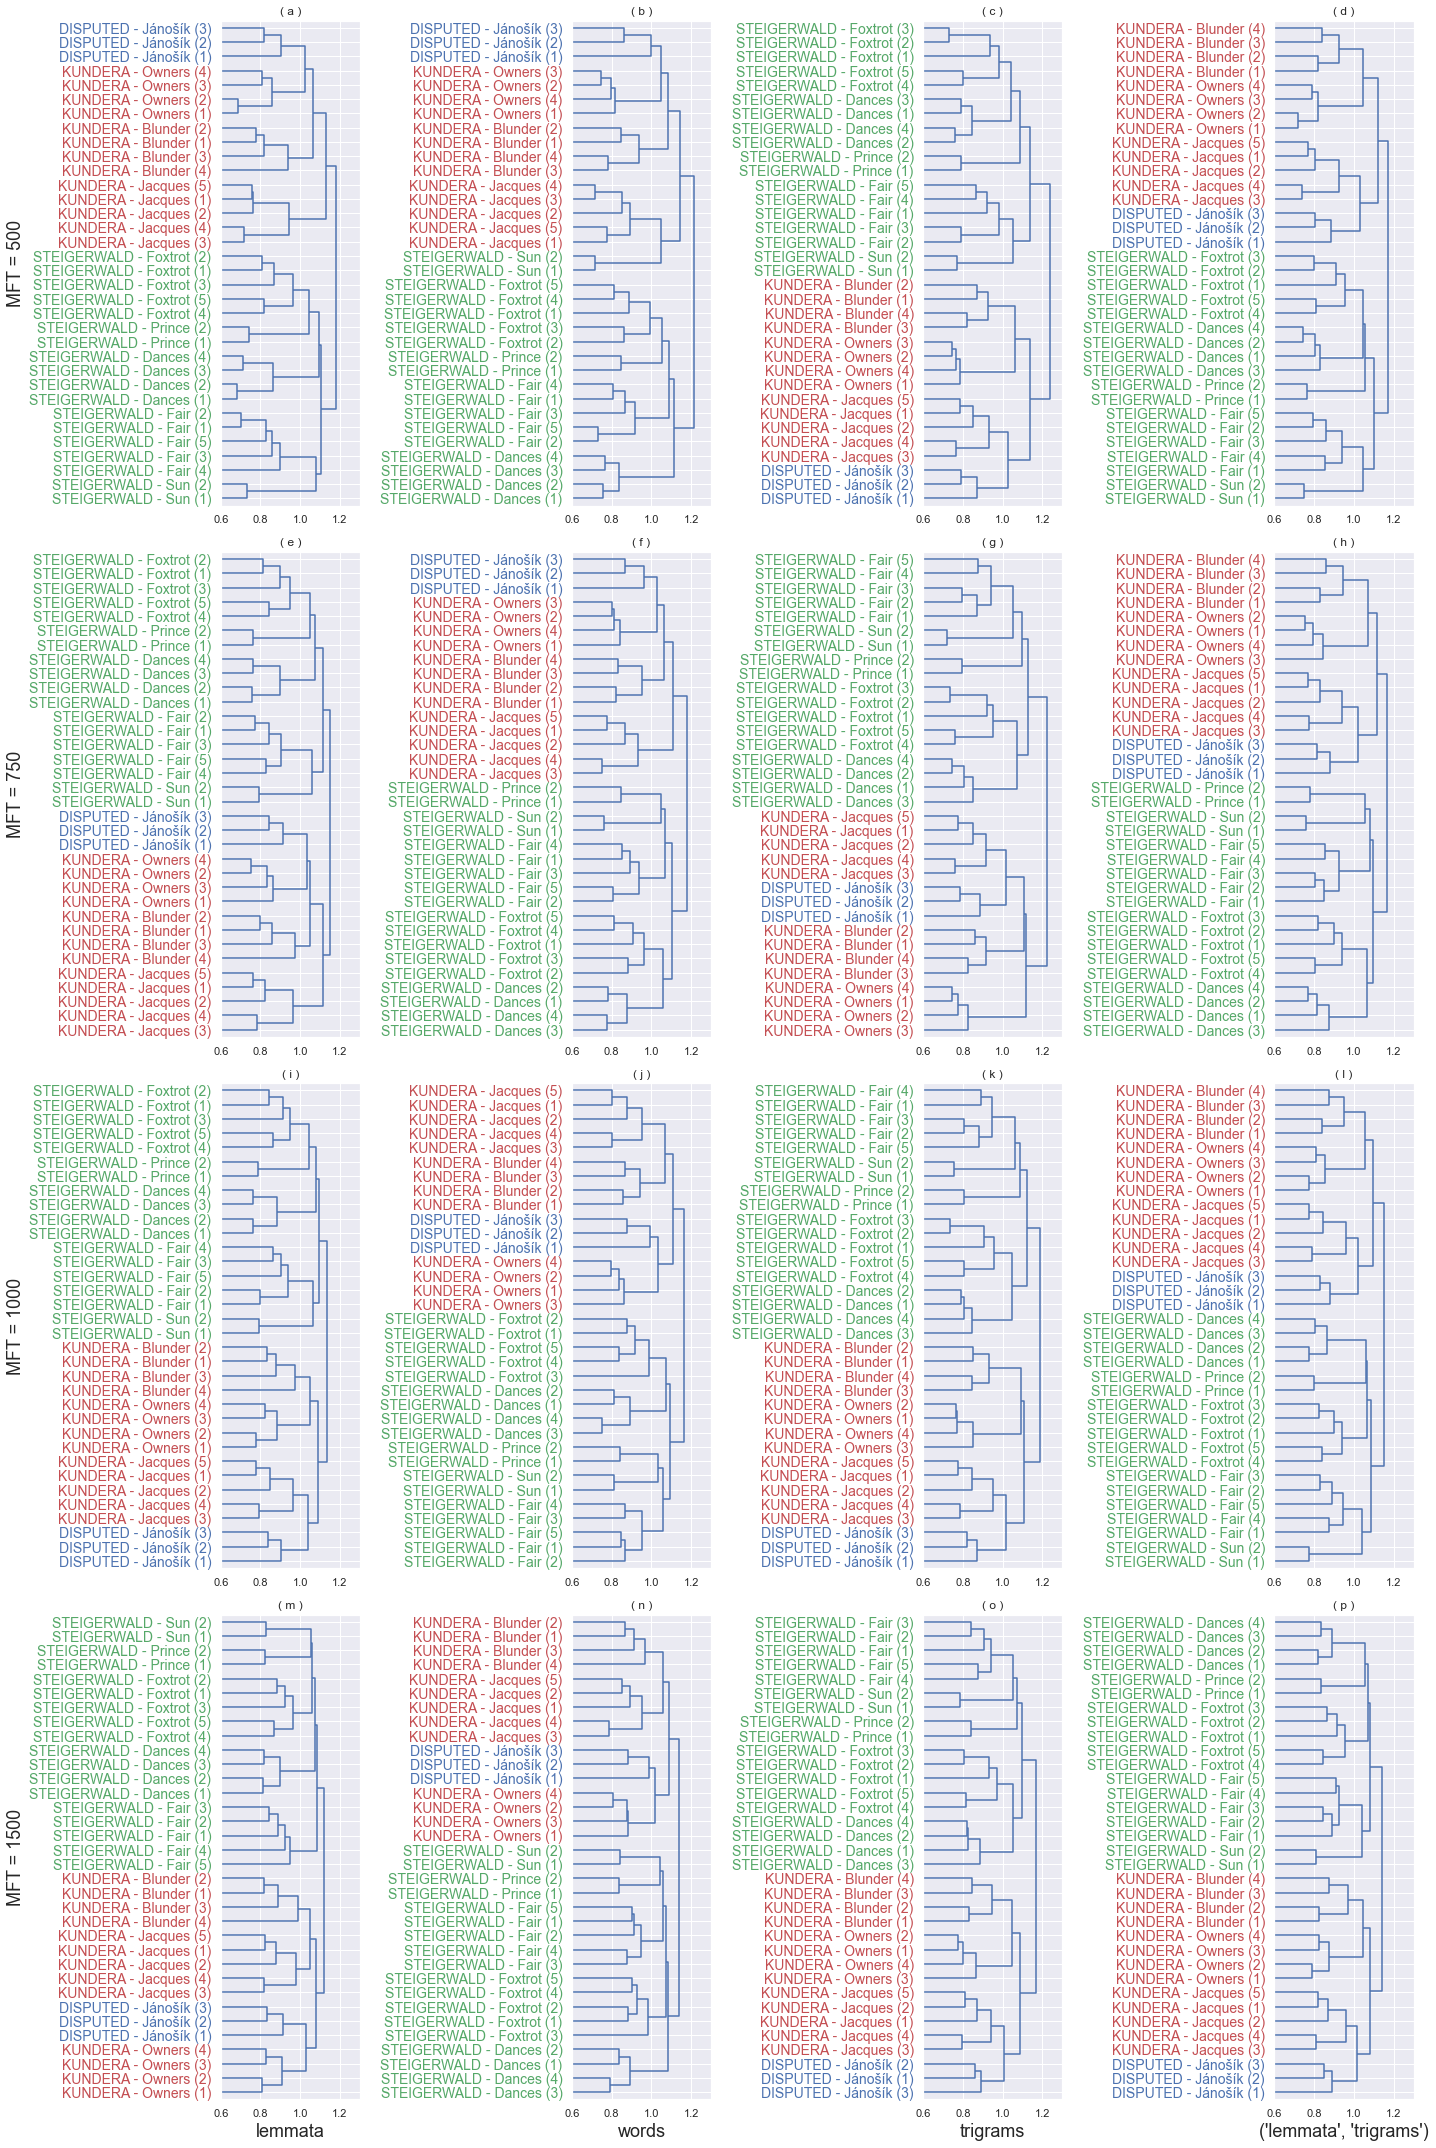

In [18]:
# Plot dendrograms based on different features and different levels of MFT
nn = plot_dendrograms(
    datasets     = datasets, 
    feature_list = ('lemmata', 'words', 'trigrams', ('lemmata', 'trigrams')), 
    mft_list     = (500, 750, 1000, 1500), 
    metric       = 'cosine', 
    method       = 'complete', 
    zscore       = True, 
    file         = 'dendrograms.pdf',
    figsize      = (20,30),
)